# 교차로와 자전거 사고간의 관계 찾기

### 사용데이터
- 자전거 사고다발지역 정보 (2012~2018) [TAAS 도로교통공단]
- 서울시 교차로 관련 정보 (2019.05.29 갱신 데이터) [서울 열린 데이터 광장]

'서울시 교차로 관련 정보' 데이터를 이용하여 __교차로 대한 단순통계 및 시각화__를 수행한다.<br>
'자전거 사고다발지역정보'와 '서울시 교차로 관련 정보' 데이터를 이용하여 __교차로수와 자전거 사고 간의 관계__를 비교 한다.

In [1]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

geo_path = 'data/seoul_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'Malgun Gothic'

## 자전거사고다발지역정보 가져오기
---------------------------------------------------------------------------------------------------------------------------------------

In [2]:
# 자전거사고다발지역정보 읽어오기
# 시도시군구명 컬럼에서 '서울특별시'가 포함된 행만 추출하여 accident_seoul 이라는 변수에 넣는다.
# 위도와 경도 컬럼에 결측치가 있을 경우 해당 행은 제거하도록 한다.

accident = pd.read_csv('data/자전거사고다발지역정보.csv', encoding = 'CP949')
accident_seoul = accident.loc[accident['시도시군구명'].str.contains('서울특별시')]
accident_seoul=accident_seoul.dropna(subset=['위도'])
accident_seoul=accident_seoul.dropna(subset=['경도'])

In [3]:
# 지점명 컬럼에 있는 내용들을 공백 마다 자르고, 두번째 단어만을 이용하여 '지역구' 컬럼에 새로이 추가한다. 
#지역구에 있는 구별로 묶을 수 있게 된다.

accident_seoul['지역구']=accident['지점명'].str.split(" ").str[1]
accident_seoul=accident_seoul.drop(['다발지역폴리곤'], axis='columns')

# size() 함수를 이용하여 지역구 별로 사고다발지가 몇군데 있는지 확인 할 수 있다.
# size() 함수를 이용한 뒤, type을 확인해보면 Series로 확인 된다. 사용에 편리를 주기 위해 Data Frame으로 변경하였다.

accident_seoul_gu = accident_seoul.groupby('지역구').size()
accident_seoul_gu = accident_seoul_gu.to_frame()
accident_seoul_gu.columns = ['사고다발지 개수']

# agg() 함수를 이용하여 지역구 별로 사고다발지에서 몇 건의 사고가 발생했는지 알 수 있다.
accident_seoul_gu_total = accident_seoul.groupby(['지역구'])[['발생건수']].agg('sum')
accident_seoul_gu_total

,발생건수
지역구,
강남구,81
강동구,308
강북구,182
강서구,161
관악구,136
광진구,318
구로구,269
금천구,101
노원구,228


## 교차로 정보 가져오기
---------------------------------------------------------------------------------------------------------------------------------------

In [4]:
crossing = pd.read_csv('data/서울시 교차로 관련 정보.csv', encoding = 'CP949')
crossing.head()

,교차로코드,입력일자,교차로명칭,유형코드,연동교차로코드,구코드 (공통),지번,구경찰서 (공통);,신경찰서 (공통);,작업구분 (공통);,...,계량기번호,도로구분 (공통);,관할사업소 (공통);,교차로관리번호,공간데이터,신규정규화ID,이력ID,동코드 (공통),공사형태 (공통);,지도표출구분
0,7130,,명덕초교입구(연등),2,2297,740,산40-3 임,310,310,1,...,,,106,82-0000006800,NaN,6268134,6800,10700,,
1,7132,,우신고후문(연등),1,1562,530,86-4전,330,330,1,...,,,104,82-0000006802,NaN,194753,6802,11000,,
2,7134,,우리유앤미아파트(연등)2,1,5464,530,501-13도,330,330,1,...,,,104,82-0000006804,NaN,1194891,6804,10200,,
3,7136,,낙성대역앞(연등),1,4494,620,산32-81 임,290,290,1,...,,,105,82-0000006806,NaN,3140241,6806,10100,,
4,7137,,제일제당앞(연등),1,1431,530,609-23도,330,330,1,...,,,104,82-0000006807,NaN,1185762,6807,10200,,


In [5]:
crossing.shape

(7233, 23)

In [6]:
crossing.groupby('구코드 (공통)').size()

구코드 (공통)
110    222
140    194
170    237
200    217
210    208
230    271
260    282
290    297
300    215
320    209
350    367
380    288
410    232
440    315
470    367
500    400
530    316
540    184
560    397
590    189
620    244
650    380
680    437
710    447
740    318
dtype: int64

In [7]:
# 데이터 사용 편리성을 위하여 새롭게 데이터 프레임을 만들었다.

crossing_new = crossing.loc[:, ['교차로명칭', '유형코드', '구코드 (공통)', '지번', '동코드 (공통)']]
crossing_new.head()

,교차로명칭,유형코드,구코드 (공통),지번,동코드 (공통)
0,명덕초교입구(연등),2,740,산40-3 임,10700
1,우신고후문(연등),1,530,86-4전,11000
2,우리유앤미아파트(연등)2,1,530,501-13도,10200
3,낙성대역앞(연등),1,620,산32-81 임,10100
4,제일제당앞(연등),1,530,609-23도,10200


In [8]:
crossing_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7233 entries, 0 to 7232
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   교차로명칭     7233 non-null   object
 1   유형코드      7233 non-null   int64 
 2   구코드 (공통)  7233 non-null   int64 
 3   지번        7233 non-null   object
 4   동코드 (공통)  7233 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 282.7+ KB


In [9]:
# '지역구'컬럼을 하나 만들었고, 해당 컬럼에는 결측치 값을 넣었다.

crossing_new['지역구'] = np.nan
crossing_new

,교차로명칭,유형코드,구코드 (공통),지번,동코드 (공통),지역구
0,명덕초교입구(연등),2,740,산40-3 임,10700,NaN
1,우신고후문(연등),1,530,86-4전,11000,NaN
2,우리유앤미아파트(연등)2,1,530,501-13도,10200,NaN
3,낙성대역앞(연등),1,620,산32-81 임,10100,NaN
4,제일제당앞(연등),1,530,609-23도,10200,NaN
...,...,...,...,...,...,...
7228,압구정현대아파트77동앞,1,680,369-1대,11000,NaN
7229,로뎀빌딩,1,680,603-2 대,10700,NaN
7230,국제기술학교,1,680,279-19 도,10800,NaN
7231,힐탑호텔,1,680,213-13 대,10800,NaN


In [10]:
# 구코드(공통)에 따른 지역구명을 결측치로 두었던 지역구 컬럼명에 넣었다.

crossing_new.loc[crossing_new['구코드 (공통)'] == 110, ['지역구']] = '종로구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 140, ['지역구']] = '중구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 170, ['지역구']] = '용산구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 200, ['지역구']] = '성동구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 210, ['지역구']] = '광진구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 230, ['지역구']] = '동대문구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 260, ['지역구']] = '중랑구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 290, ['지역구']] = '성북구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 300, ['지역구']] = '강북구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 320, ['지역구']] = '도봉구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 350, ['지역구']] = '노원구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 380, ['지역구']] = '은평구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 410, ['지역구']] = '서대문구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 440, ['지역구']] = '마포구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 470, ['지역구']] = '양천구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 500, ['지역구']] = '강서구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 530, ['지역구']] = '구로구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 540, ['지역구']] = '금천구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 560, ['지역구']] = '영등포구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 590, ['지역구']] = '동작구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 620, ['지역구']] = '관악구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 650, ['지역구']] = '서초구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 680, ['지역구']] = '강남구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 710, ['지역구']] = '송파구'
crossing_new.loc[crossing_new['구코드 (공통)'] == 740, ['지역구']] = '강동구'

crossing_new

,교차로명칭,유형코드,구코드 (공통),지번,동코드 (공통),지역구
0,명덕초교입구(연등),2,740,산40-3 임,10700,강동구
1,우신고후문(연등),1,530,86-4전,11000,구로구
2,우리유앤미아파트(연등)2,1,530,501-13도,10200,구로구
3,낙성대역앞(연등),1,620,산32-81 임,10100,관악구
4,제일제당앞(연등),1,530,609-23도,10200,구로구
...,...,...,...,...,...,...
7228,압구정현대아파트77동앞,1,680,369-1대,11000,강남구
7229,로뎀빌딩,1,680,603-2 대,10700,강남구
7230,국제기술학교,1,680,279-19 도,10800,강남구
7231,힐탑호텔,1,680,213-13 대,10800,강남구


In [11]:
crossing_new.isnull().sum()

교차로명칭       0
유형코드        0
구코드 (공통)    0
지번          0
동코드 (공통)    0
지역구         0
dtype: int64

In [12]:
# 지역구별로 교차로 개수를 확인할 수 있다.

crossing_gu = crossing_new.groupby('지역구').size()
crossing_gu = crossing_gu.to_frame()
crossing_gu.columns = ['교차로개수']
crossing_gu

,교차로개수
지역구,
강남구,437
강동구,318
강북구,215
강서구,400
관악구,244
광진구,208
구로구,316
금천구,184
노원구,367


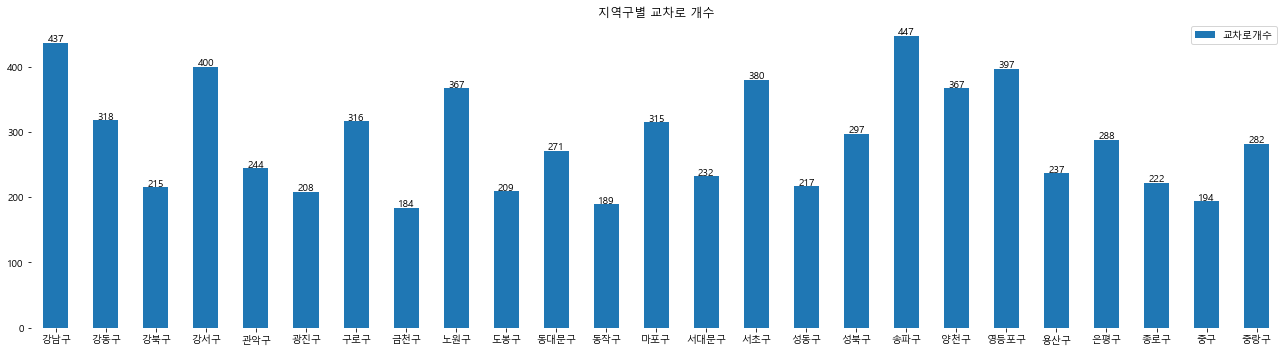

In [13]:
# 지역구별 교차로 개수를 그래프로 표시하였다

ax = crossing_gu.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구별 교차로 개수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

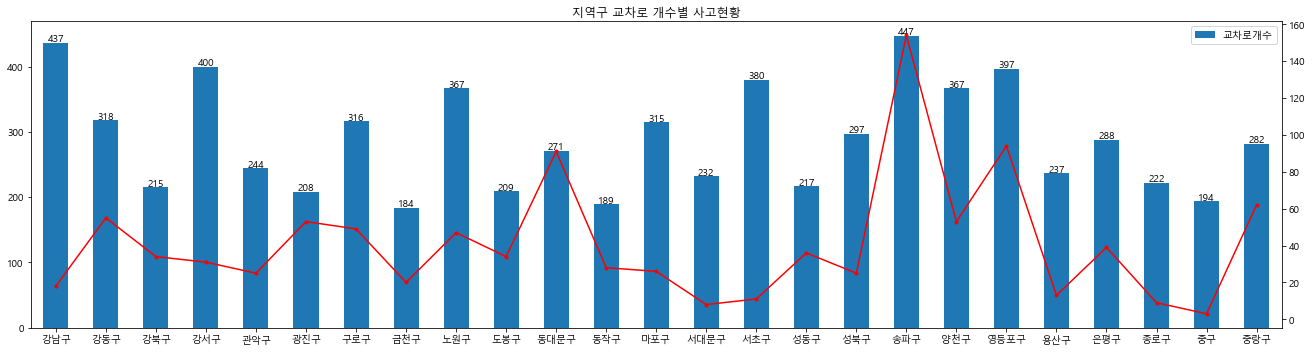

In [14]:
# 지역구별 교차로 개수와 지역구별 사고다발지 실제 사고 건수를 비교하였다.

ax = crossing_gu.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구 교차로 개수별 사고현황")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')

plt.box(False)
plt.xlabel('')
plt.tight_layout()

plt.twinx() # bar 그래프와 plot 그래프 합치기
plt.plot(accident_seoul_gu ,'r.-')
plt.show()

## 대여소수/거치대수와 사고다발지 실제 건수 간의 상관관계 비교
---------------------------------------------------------------------------------------------------------------------------------------

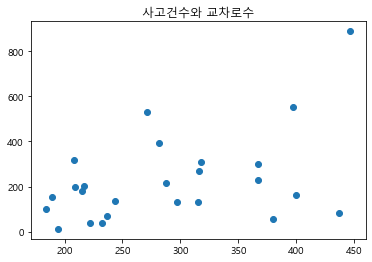

In [15]:
from sklearn.linear_model import LinearRegression

plt.plot(crossing_gu['교차로개수'], accident_seoul_gu_total['발생건수'], 'o')
plt.title('사고건수와 교차로수')
plt.show()

In [16]:
line_fitter = LinearRegression()
line_fitter.fit(crossing_gu['교차로개수'].values.reshape(-1,1), accident_seoul_gu_total['발생건수'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

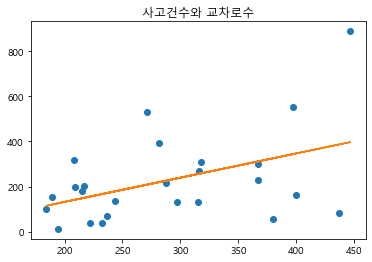

In [17]:
plt.plot(crossing_gu['교차로개수'], accident_seoul_gu_total['발생건수'], 'o')
plt.plot(crossing_gu['교차로개수'],line_fitter.predict(crossing_gu['교차로개수'].values.reshape(-1,1)))
plt.title('사고건수와 교차로수')
plt.show()

In [18]:
import scipy.stats as stats

corr = stats.pearsonr(crossing_gu['교차로개수'], accident_seoul_gu_total['발생건수'])
corr

(0.4442218505633099, 0.026104613643711496)